# <center>Data Science Assignment 1</center>

## Team details:
### Jivitesh Gudekar (B00803338)
### Vismay Revankar (B00813441)

#### Please note that some of the questions have not been done in the correct order. This is because of the structure of the functions/code

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing as sk
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Mount Google drive to Colab to access the dataset

#from google.colab import drive
#drive.mount('/content/gdrive')


## 1. Introduction. (2 marks)
### a. Explain the dataset with your own words. Focus on the attributes description. (2 marks)
<b>Answer:</b> The dataset contains restaurant details about restaurants in Bangalore, India taken from Zomato (A restaurant review website). It contains the following columns:
<li>URL - The URL of the restaurant's page on Zomato.
<li>address - The address of the restaurant as a string.
<li>name - Name of the restaurant.
<li>online_order - Shows if the restaurant accepts online orders (Yes or No).
<li>book_table - Shows if one can book a table at the restaurant (Yes or No).
<li>rate - The average user rating (out of 5) for the restaurant.
<li>votes - Number of users who have rated the restaurant.
<li>phone - The contact number of the restaurant.
<li>location - The location or neighbourhood of the restaurant in Bangalore.
<li>rest_type - The type of the restaurant (eg. Casual Dining, Cafe, Quick Bites, Pub, Bar, etc.).
<li>dish_liked - The dishes liked by customers at the restaurant.
<li>cuisines - The type of food served at the restaurant (eg. North Indian, Mughlai, Chinese, Mexican, Italian, etc.).
<li>approx_cost(for two people) - The average cost for a meal for two people at the restaurant.
<li>reviews_list - The reviews given by the users.
<li>menu_item - The names of dishes served at the restaurant
<li>listed_in(type) - The type of dining the restaurant offers.
<li>listed_in(city) - The neighborhood of the restaurant.

<br>
<b>Columns selected for model-building:</b><br>
After carefully evaluating all columns, the columns we have decided to use to build our model are:
<li> <b>location</b>: Rather than label encode the locations, we have calculated the average cost for two location-wise. This provides the model with insights on which locations are posh and tend to have more expensive restaurants. While this hypothesis is not a 100% fool-proof, it does provide a general intuition of the price of a restaurant based on its location. This is because, it is unlikely for very expensive restaurants to be located in "less-developed" areas. Rather, you will find the more expensive restaurants in busy, commercial locations. A similar intuition holds true for the opposite scenario too.
<li> <b>rest_type </b>: Similar to the location attribute, we are calculating the average cost of a meal for 2 based on the restaurant type (rest_type). This provides the model with insights on how the cost of a restaurant can vary based on its type. Example: Fast-food outlets tend to be cheap, whereas, fine-dining or restaurants with exotic cuisines tend to cost more.
<li> <b>cuisines</b>: As stated above, the type of a restaurant can affect its price. Similarly, the cuisines served at a restaurant affect the price too. For this column, we are using a MultiLabelBinarizer to encode the cuisines served at a restaurant.
<li> <b>online_order</b>: The idea behind considering this column for model building is that, very cheap and very expensive places tend to not provide the facility to order online. Hence, providing this information to the model identifies the category into which the restaurant falls. We have used Binary encoding for this column (1 for Yes, 0 for No.)
<li><b>book_table</b>: The idea behind considering this column is similar to why we chose online_order. Fast-food joints and other smaller restaurants do not provide the facility to book tables. Only restaurants that cost more than the average value tend to provide table booking facility. Hence, to provide this information to the model, we have used the column. We have used binar encoding for this column as well (1 for Yes, 0 for No).
<li><b>listed_in(type)</b>: This column is similar to the rest_type column. It identifies the type of restaurants, which is a very important attribute when considering the price of a restaurant. Hence, we have used this column. We have used One-Hot-Encoding to encode this column.<br> <br>


<b> Justification for not using the rate column: </b><br>
It was mentioned in the assignment problem statement that we were to use the rating column to build the model. However, after a lot of thought, we concluded that it is not a very good attribute in determining the price of a restaurant. Here is why:
<li> There is no direct correlation between price and ratings of a restaurant. You can find very highly rated restaurants which are very cheap (example a popular fast-food joint). Likewise, a highly-rated 5-star hotel will be very expensive. The same holds true for the converse i.e low-rated restaurants.
<li> The rate column has ~2000 'NEW' values. This implies that a restaurant is new, and hence, has not been rated. Substituting 'NEW' with 0 or the avg. rating of all restaurants have down-sides. <br><br>
Hence, for the above reasons, we have not used the rate column to build our model.

In [3]:
def load_data_from_file(dataset_filepath):
    df_dataset = pd.read_csv(dataset_filepath)
    return df_dataset

In [4]:
def label_encode(column):
    lab_enc = sk.LabelEncoder()
    lab_enc.fit(column)
    label_encoded = lab_enc.transform(column)
    label_encoded = np.reshape(label_encoded, (label_encoded.shape[0],1))
    return label_encoded

In [5]:
def one_hot_encode(column, label_encoding_needed=False):
    ohe_enc = sk.OneHotEncoder(sparse=False)
    if label_encoding_needed:
        lab_encoded_column = label_encode(column)
        ohe_enc.fit(lab_encoded_column)
        ohe_result = ohe_enc.transform(lab_encoded_column)
    else:
        ohe_enc.fit(column)
        ohe_result = ohe_enc.transform(column)
    return ohe_result

In [6]:
# This method handles preprocessing tasks that are to be exclusively done for training data

def preprocess_training_data(df):
    # Calculate mean cost per location i.e average cost of all restaurants in a given area
    # Add a new column in df with means corresponding to the restaurant locations
    mean_cost_location = df.groupby('location', as_index=False)['approx_cost(for two people)'].mean()
    mean_cost_location.rename(columns={'approx_cost(for two people)':'mean_cost'}, inplace=True)
    df['mean_cost_by_location'] = 0.0
    locations = mean_cost_location['location'].tolist()
    for location in locations:
        indices = df.index[df['location'] == location].tolist()
        mean_cost = mean_cost_location[mean_cost_location['location'] == location]['mean_cost'].tolist()[0]
        df['mean_cost_by_location'][indices] = mean_cost

    # Calculate mean cost per restaurant type i.e avg cost of restaurants per rest_type
    mean_cost_rest_type = df.groupby('rest_type', as_index=False)['approx_cost(for two people)'].mean()
    mean_cost_rest_type.rename(columns={'approx_cost(for two people)':'mean_cost'}, inplace=True)
    df['mean_cost_by_rest_type'] = 0.0
    restaurant_types = mean_cost_rest_type['rest_type'].tolist()
    for rest_type in restaurant_types:
        indices = df.index[df['rest_type'] == rest_type].tolist()
        mean_cost = mean_cost_rest_type[mean_cost_rest_type['rest_type'] == rest_type]['mean_cost'].tolist()[0]
        df['mean_cost_by_rest_type'][indices] = mean_cost

    return df


In [7]:
# This method handles preprocessing tasks that are to be exclusively done for validation/test data

def preprocess_validation_data(train_data, val_data):
    # Create and update the column: val_data['mean_cost_by_location']
    # Get a list of unique location names in the validation data and train data
    locations_in_val = val_data['location'].unique().tolist()
    locations_in_train = train_data['location'].unique().tolist()

    # Get mean prices by location from the train data
    location_wise_mean_price = dict()
    for location in locations_in_train:
        mean_price = train_data[train_data['location']==location]['mean_cost_by_location'].tolist()[0]
        location_wise_mean_price[str(location)] = mean_price    

    val_data['mean_cost_by_location'] = 0.0
    for location in locations_in_val:
        if location in locations_in_train:
            indices = val_data.index[val_data['location'] == location].tolist()
            mean_cost = location_wise_mean_price[location]
            val_data['mean_cost_by_location'][indices] = mean_cost

    # Create and update the column: val_data['mean_cost_by_rest_type']
    # Get a list of rest_types in val and train data
    rest_types_in_val = val_data['rest_type'].unique().tolist()
    rest_types_in_train = train_data['rest_type'].unique().tolist()

    # Get mean prices by rest_type from the train data
    rest_type_wise_mean_price = dict()
    for rest_type in rest_types_in_train:
        mean_price = train_data[train_data['rest_type']==rest_type]['mean_cost_by_rest_type'].tolist()[0]
        rest_type_wise_mean_price[str(rest_type)] = mean_price

    val_data['mean_cost_by_rest_type'] = 0.0
    for rest_type in rest_types_in_val:
        if rest_type in rest_types_in_train:
            indices = val_data.index[val_data['rest_type']==rest_type].tolist()
            mean_cost = rest_type_wise_mean_price[rest_type]
            val_data['mean_cost_by_rest_type'][indices] = mean_cost
    return val_data


In [8]:
# This method drops all rows with Nan/nulls in them

def drop_nulls_from_dataset(df):
    # Remove commas from in between the digits
    df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(",","")

    # Drop rows from the dataset with NaN in the "approx_cost(for two people)" column
    df = df.dropna(subset=['approx_cost(for two people)'])

    # Convert the "approx_cost(for two people)" column to int
    df['approx_cost(for two people)'] = df['approx_cost(for two people)'].astype(int)
    
    # Drop duplicate restaurant entries based on name and address column
    df = df.drop_duplicates(subset=['name','address'], keep='first')

    # Drop columns that will not be used for preprocessing
    cols_to_drop = ['url','phone','reviews_list','menu_item','votes', 'dish_liked', 'listed_in(city)']
    df = df.drop(cols_to_drop, axis=1)
    
    # Removing the /5 and replacing nan by NEW as votes are 0 for the row
    # print(zomato['rate'].value_counts())
    # zomato['rate'] = zomato['rate'].replace('/5', '')
    # Changed NaN to NEW as these were new restaurants
    df['rate'] = df['rate'].str.replace('nan', 'NEW').astype(str)
    df['rate'] = df['rate'].str.strip()
    df['rate'] = df['rate'].str.replace('-', '0')
    df['rate'] = df['rate'].astype(str).map(lambda x: x.rstrip('/5'))
    df['rate'] = df['rate'].str.replace('NEW', '0').astype(float)
    df['rate'] = df['rate'].astype(float)

    # Detect nulls in columns and drop those rows
    df = df.dropna()
    
    # Reset indices after dropping rows
    df = df.reset_index(drop=True)    
    
    # Encode cuisines
    mlb = MultiLabelBinarizer()
    mlb_encoded = pd.DataFrame(mlb.fit_transform(df['cuisines']))    
    df = pd.concat([df, mlb_encoded], axis=1)

    # Encode listed_in(type)
    numeric_column_index = mlb_encoded.columns[-1] + 1
    
    ohe_listed_in = one_hot_encode(df['listed_in(type)'], True)
    column_names = list(range(numeric_column_index, numeric_column_index + ohe_listed_in.shape[1]))
    ohe_df = pd.DataFrame(data=ohe_listed_in, columns=column_names)
    df = pd.concat([df, ohe_df], axis=1)
 
    # Encode online_order
    df['order_online'] = df.online_order.map(dict(Yes=1.0, No=0.0))
    
    # Encode book_table
    df['table_booking'] = df.book_table.map(dict(Yes=1.0, No=0.0))
            
    return df


In [9]:
def avg_error(error_scores):
    return sum(error_scores)/len(error_scores)

In [10]:
# Reference: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/figure_title.html
# Reference: https://thispointer.com/python-how-to-create-a-list-and-initialize-with-same-values/
# Reference: https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-most-simple-manner-possible
# Reference: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots

def plot_rms_error(error_scores, model_name, plt_number, legend_loc='lower left'):
    plt_number.set_title(model_name)
    plt_number.set_xlabel("K-fold cross-validation iterations")
    plt_number.set_ylabel("Error")    
    model_avg_score = [avg_error(error_scores)]*len(error_scores)
    plt_number.plot(error_scores, 'gx-', label='RMS error values')
    plt_number.plot(model_avg_score, 'rx-', label='Mean RMS error')
    plt_number.legend(loc=legend_loc)

## 2. Data pre-processing and understanding. (28 marks total)
### 2. a. Load the data. (3 marks)
<b>Answer:</b> The following cell invokes a function to load the dataset from the CSV file. 

In [11]:
# Load the data from the csv file
#dataset_filepath = './gdrive/My Drive/zomato2.csv'
dataset_filepath = './Dataset/zomato2.csv'
df_dataset = load_data_from_file(dataset_filepath)

In [12]:
# Preprocess the data
raw_dataset = drop_nulls_from_dataset(df_dataset)

data = preprocess_training_data(raw_dataset)

# Seperate the feature and label columns into seperate dataframes and drop uneccesary columns
labels = pd.DataFrame()
labels['approx_cost(for two people)'] = data['approx_cost(for two people)']

### 2. c. Are there restaurant duplicates in the data? Detect and if there is, clean it. (5 marks)
<b>Answer: </b> Yes, there are many duplicates in the data. Before cleaning, there were ~51,000 rows in the dataset. However, after removing duplicates and dropping rows with null values, only 12,380 rows remain.<br><br>
We have dropped duplicates by matching restaurants with name and address. This is the ideal way to determine duplicates, rather than comparing only by name or by comparing across all attributes. The code used to drop duplicates can be found in line 13 of the function drop_nulls_from_dataset(): <br><br>
    <center>    df = df.drop_duplicates(subset=['name','address'], keep='first') </center>

### 2. d. What is the neighborhood with the highest average rating? 
<br>
### What are the major characteristics of this neighborhood (e.g., type of restaurant, type of food they offer, etc). (10 marks)
<b>Answer:</b> 


In [13]:
# Get avg. ratings per location
df_grouped_locations=data.groupby(['location'], as_index=False)['rate'].mean()

# Get best rated location
best_rated_location = df_grouped_locations.loc[df_grouped_locations['rate'] == max(df_grouped_locations['rate']), 'location'].iloc[0]
rating_of_best_location = max(df_grouped_locations['rate'])
print(f"Location with highest average rated restaurants is: {best_rated_location} and the average rating is {rating_of_best_location}\n")

# Get cuisines served in the best rated area
cuisines_served = data[data['location']==best_rated_location]['cuisines'].unique()
print(f"The cuisines served in {best_rated_location} are: {cuisines_served}\n")

# Restaurant types in the best location
rest_types = data[data['location']==best_rated_location]['rest_type'].unique()
print(f"The restaurant types on {best_rated_location} are: {rest_types}\n")

# Mean price for two in best location
mean_price = data[data['location']==best_rated_location]['mean_cost_by_location'].tolist()[0]
print(f"The mean price for a mean in {best_rated_location} is {mean_price}")

Location with highest average rated restaurants is: Sankey Road and the average rating is 4.041666666666666

The cuisines served in Sankey Road are: ['North Indian, Continental, Japanese, Chinese, South Indian'
 'Continental, Chinese, North Indian' 'Finger Food'
 'North Indian, Mughlai' 'North Indian, Continental, Asian' 'North Indian'
 'Desserts, Ice Cream, Beverages' 'South Indian' 'European']

The restaurant types on Sankey Road are: ['Fine Dining' 'Club' 'Lounge' 'Casual Dining' 'Dessert Parlor' 'Bar']

The mean price for a mean in Sankey Road is 2695.8333333333335


### 2. b. Explore the data. Plot the distribution of the attributes (frequency). What trends can you find in your data? Are there attributes that are useless at this point? (10 marks)
<b>Answer:</b> From the frequency distribution of approx cost plotted below in the graph shows that a lot of restaurants range in below Rs. 1000 range. Most of the restaurants have Rs. 500 for the price cost of two.
<br>
The attributes URL, phone number, name, dish_liked, review list, menu_item seem to be useless to predict the cost of two people.

Plot of mean cost of restaurant per location

Text(0,0.5,'approx_cost(for two people)')

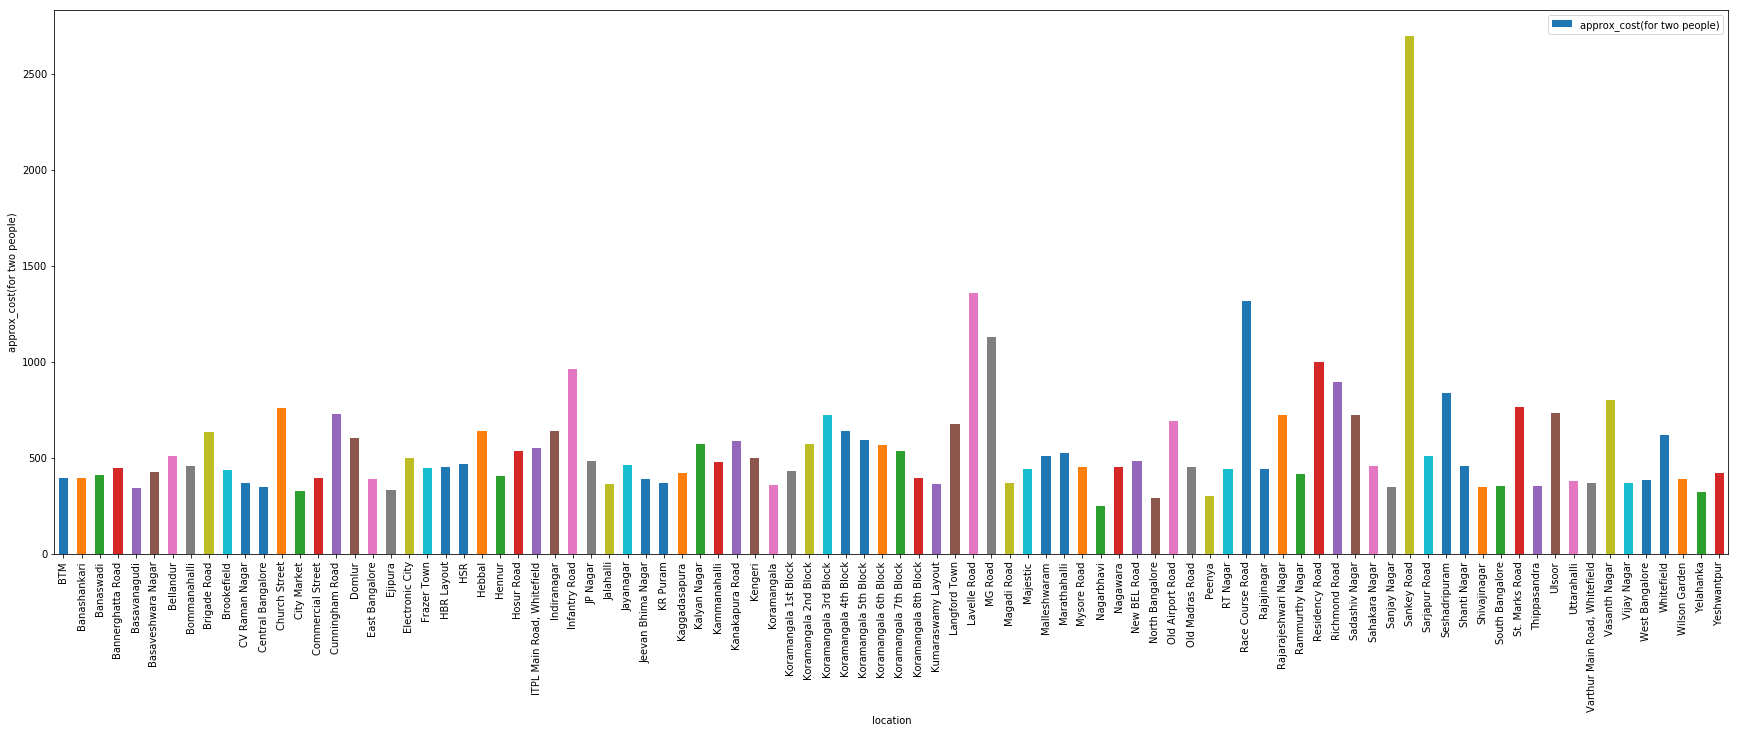

In [14]:
location_wise_cost = data.groupby('location')['approx_cost(for two people)'].mean()
location_wise_cost.plot(kind='bar', figsize=(30,10), legend=True).set_ylabel('approx_cost(for two people)')

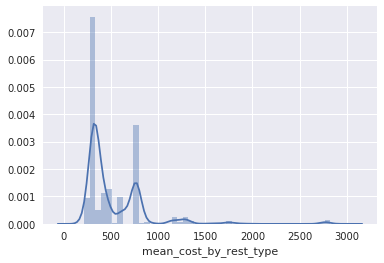

In [15]:
# Plotting distribution based on restaurant type
sns.set(); np.random.seed(0)
ax = sns.distplot(data['mean_cost_by_rest_type'])

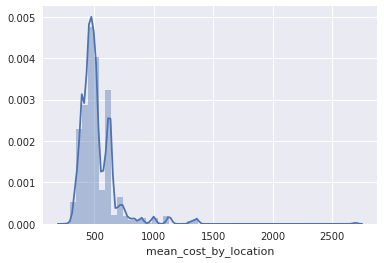

In [16]:
# Plotting distribution based on location
sns.set(); np.random.seed(0)
ax = sns.distplot(data['mean_cost_by_location'])

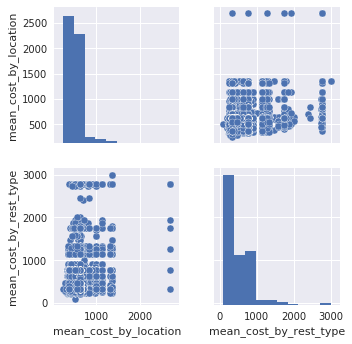

In [17]:
# mean_cost_by_location vs. mean_cost_by_rest_type
data_subset = data[['mean_cost_by_location', 'mean_cost_by_rest_type']]
sns.pairplot(data_subset);

## 3. Build the best model you can that forecasts the approximate cost of a meal for two people using the attributes location, rating, restaurant type, and cuisine. (70 marks total) 

### 3. a. Explain what is the task you’re solving (e.g., supervised x unsupervised, classification x regression x clustering or similarity matching x etc). (5 marks)
<b>Answer:</b> The task is to predict cost of a meal for two people in a given restaurant. This is a <b>supervised problem</b> as the labels for the datset are given. Moreover, we are predicting the cost for two people in Rupees (currency) which makes it a <b>regression problem</b>. <br>

We could have treated this as a classification problem by binning the various prices into categories. However, we found the regression model to be pretty accurate and hence, did not see the necessity of treating it as a classification problem.


### 3. b. What models will you choose? Why? (5 marks)
<b>Answer:</b> We chose the following six models to build:
<li> Linear Regression
<li> Decision Tree
<li> Random Forest
<li> MLP
<li> SVR
<li> AdaBoost
<br>
These are the most widely used regression models, and that is the reason we decided to evaluate the best model among them. <br>
Among the six models, we found the error of 3 models to be the least and almost similar to one-another. These models are: 
<li> Linear Regression
<li> Random Forest Regressor
<li> MLP Regressor
    
Since the mean errors of the 3 models were very similar, we plotted them together, in a graph. This gave us a clearer idea on which model to choose. As seen from the graph <i>Avg. error with Linear Regression v/s MLP Regressor v/s Random Forest Regressor'</i>, Random Forest Regressor performs better and more consistently than the other two models. Hence, we decided to choose <b>Random Forest Regressor</b>.

In [18]:
# Drop columns that will not be used to build the model
columns_to_drop = ['name','approx_cost(for two people)','location','rest_type', 'listed_in(type)', 
                   'address', 'cuisines', 'online_order', 'book_table', 'rate']

data = data.drop(columns_to_drop, axis=1)

In [19]:
# Find the best fitting model for the data using k-fold cross-validation
cost_function = 'neg_mean_absolute_error'
# Linear Regression
linear_reg_cv_score = cross_val_score(LinearRegression(), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

# Support Vector Regressor.
sv_reg_cv_score = cross_val_score(SVR(), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

#Decision Tree Regressor
tree_reg_cv_score = cross_val_score(DecisionTreeRegressor(), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

# Random Forest Regressor
rf_reg_cv_score = cross_val_score(RandomForestRegressor(), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

# AdaBoost Regressor
adaboost_reg_cv_score = cross_val_score(AdaBoostRegressor(n_estimators=75), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

# Multi-layer perceptron (Neural Net)
mlp_reg_cv_score = cross_val_score(MLPRegressor(), data, labels, scoring=cost_function, cv=10, n_jobs=-1)

### 3. c. Which metrics will you use to evaluate your model? (5 marks)
<b>Answer:</b> We chose <b>Mean Absolute Error (MAE)</b> and <b>Mean Squared Error (MSE)</b> as the metrics to evaluate the error. The error graps for all the models are shown below.<br>

MAE provides us with information on 'how wrong' are predictions are, with respect to the actuall value. However, we also used MSE, because it provides information on the magnitude of 'the worst predictions/mistakes'. That way, we will also know the degree by which we are going wrong in the worst-case.

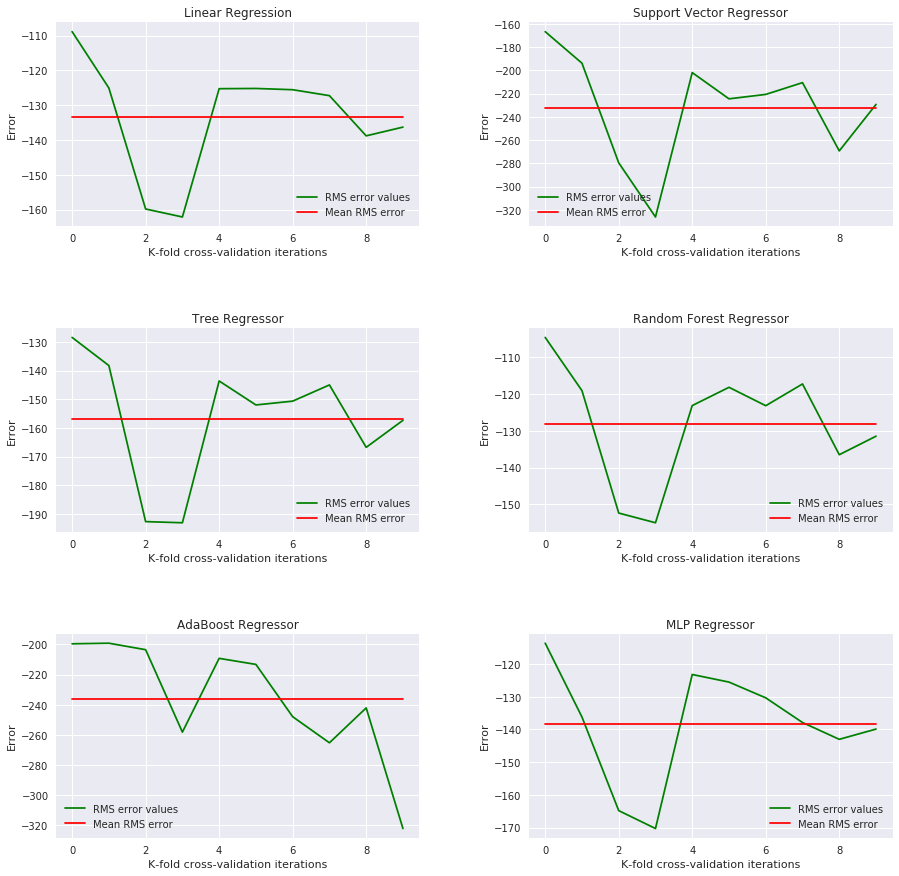

In [20]:
# Reference: https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
fig, ax_array = plt.subplots(3,2, sharex=False, sharey=False, figsize=(15,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plot_rms_error(linear_reg_cv_score, "Linear Regression", ax_array[0,0], 'lower right')
plot_rms_error(sv_reg_cv_score, "Support Vector Regressor", ax_array[0,1], 'lower left')
plot_rms_error(tree_reg_cv_score, "Tree Regressor", ax_array[1,0], 'lower right')
plot_rms_error(rf_reg_cv_score, "Random Forest Regressor", ax_array[1,1], 'lower right')
plot_rms_error(adaboost_reg_cv_score, "AdaBoost Regressor", ax_array[2,0], 'lower left')
plot_rms_error(mlp_reg_cv_score, "MLP Regressor", ax_array[2,1], 'lower right')

In [21]:
print(f"Average error for Linear Regression: {avg_error(linear_reg_cv_score)}")
print(f"Average error for Decision Tree: {avg_error(tree_reg_cv_score)}")
print(f"Average error for Random Forest Regressor: {avg_error(rf_reg_cv_score)}")
print(f"Average error for MLP: {avg_error(mlp_reg_cv_score)}")
print(f"Average error for SVR: {avg_error(sv_reg_cv_score)}")
print(f"Average error for ABR: {avg_error(adaboost_reg_cv_score)}")

Average error for Linear Regression: -133.43487693966787
Average error for Decision Tree: -156.7823001366408
Average error for Random Forest Regressor: -128.10859801509744
Average error for MLP: -138.47538630440323
Average error for SVR: -232.28695485135876
Average error for ABR: -236.04139178055252


### 3. e. Build your model and verify how it performs (using the metrics you have chosen in Section 3(c)) in your training data. Justify which evaluation approach you are using?(Out of sample validation or Cross-validation). Use a plot to justify your findings. How good is your model? (10 marks).
<b>Answer:</b> To select the best performing model from the 6 choices, we used <b>K-fold cross-validation</b>. This approach reduces the bias and increases the variance in the mean error as it calculates the mean error for each iteration of cross-validation.<br>
After selecting the best model using K-fold cross-validation, we built the model and fine-tuned the hyper-parameters using GridSearchCV. In this case, we used <b>hold-out cross validation</b> to determine if the model was overfitting/underfitting or generalising well.<br><br>
To summarize:
    <li> <b>K-fold cross validation</b> was used to choose the best fitting model out of a choice of 6 models.
    <li> <b>Hold-out cross-validation</b> was used on the tuned model to check for overfitting/underfitting. The chosen model's hyper-parameters were first fine-tuned using GridSearchCV.
<br><br>
It can be seen from the graphs that MLP and Random Forest  and Linear Regression perform the best as they have the least error. We discarded Linear Regression as it did not perform as consistently as the other 2 models. We chose Random Forest over MLP as neural networks usually perform very well on large datasets (millions of samples). However, with just ~12,000 samples, there was not much scope to further increase the performance of a neual network. Hence, we chose the Random Forest Regressor as our model.

#### Comparing the 3 lowest errors: Linear Regression v/s MLP v/s Random Forest

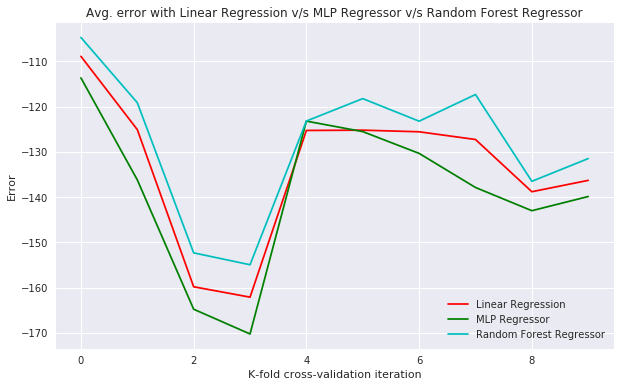

In [22]:
plt.figure(figsize=(10,6))
plt.title('Avg. error with Linear Regression v/s MLP Regressor v/s Random Forest Regressor')
plt.xlabel('K-fold cross-validation iteration')
plt.ylabel('Error')
plt.plot(linear_reg_cv_score, 'rx-', label='Linear Regression')
plt.plot(mlp_reg_cv_score, 'gx-', label='MLP Regressor')
plt.plot(rf_reg_cv_score, 'cx-', label='Random Forest Regressor')
plt.legend(loc='lower right')
plt.show()

From the above graph, it can be seen that Random Forest Regressor consistently performs better than the other 2.

### 3. d. How do you make sure not to overfit? (5 marks)
<b>Answer:</b> To ensure the model does not overfit, we used hold-out validation. We used train_test_split to get a validation dataset. Once the model was built and the hyper-parameters were fine-tuned, we:<br>
1) Evaluated the model on the training data to obtain <b>training error</b> <br>
2) Evaluated the model on the validation data to obtain <b>validation error</b> <br><br>

Then, we compared the 2 errors obtained:
<li> If train error was high, then the model underfits.
<li> If train error was low, but the validation error was high, The model overfits as it does not generalise well to unseen data.
<li> If train and validation error are low, and around the same range, the model is a good fit and it generalises well.

In [23]:
# Re-load the dataset and this time, use train_test_split to  split the data and build
# a model using the train data, fine-tune the hyper-parameters using GridSearchCV
# and then evaluate the performance of the model on the validation data. 

df_dataset = load_data_from_file(dataset_filepath)

# Preprocess the data
raw_dataset = drop_nulls_from_dataset(df_dataset)
print(f"Shape of raw_Dataset is {raw_dataset.shape}")

# Seperate attributes and labels
raw_labels = pd.DataFrame()
raw_labels['approx_cost(for two people)'] = raw_dataset['approx_cost(for two people)']
raw_data = raw_dataset.drop(['approx_cost(for two people)'], axis=1)

# Use train_test_split() to split the dataset into train and val datasets
X_train, X_val, y_train, y_val = train_test_split(raw_data, raw_labels, test_size=0.3, random_state=42)

# Merge the corresponding attributes and labels to pass if for preproccessing
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

clean_training_data = preprocess_training_data(train_data)

clean_val_data = preprocess_validation_data(clean_training_data, val_data)

# Drop unecessary column just before runnings models
columns_to_drop = ['name','location','rest_type', 'listed_in(type)', 
                   'address', 'cuisines', 'online_order', 'book_table','rate']

clean_training_data = clean_training_data.drop(columns_to_drop, axis=1)
clean_val_data = clean_val_data.drop(columns_to_drop, axis=1)

Shape of raw_Dataset is (10023, 69)


In [24]:
clean_training_data = clean_training_data.reset_index(drop=True)
y_train = clean_training_data['approx_cost(for two people)']
X_train = clean_training_data.drop(['approx_cost(for two people)'], axis=1)

clean_val_data = clean_val_data.reset_index(drop=True)
y_val = clean_val_data['approx_cost(for two people)']
X_val = clean_val_data.drop(['approx_cost(for two people)'], axis=1)

In [25]:
model = RandomForestRegressor().fit(X_train, y_train)
predictions = model.predict(X_val)

In [26]:
print(f" The error of the Random Forest Regressor without hyper-parameter tuning is: {mean_absolute_error(y_val, predictions)}")

 The error of the Random Forest Regressor without hyper-parameter tuning is: 132.52119605318188


### 3. g. Can you tune your model to perform better? Explain the technique you’re using and justify why it is improving your results. (25 marks)
<b>Answer:</b> To reduce the error rate we tuned the hyperparameters of Random Forest using Grid SearchCV. This repeatedly builds the model using different hyper-parameter settings until the optimal one is found. For K-fold Cross-validation (during model selection) the default hyperparamteres were used. Whereas, in GridSearchCV we provided a list of hyperparameters to tune the model. The model with the best hyperparamers is chosen by GridSearchCV, therefore, we see an improvement in the results. <br>
Lastly, we compare training error to validation error to ensure that the model is a good fit and generalises well (i.e, it does not underfit or overfit).

In [27]:
print(datetime.now())
rfc_parameters = {'criterion':['mse', 'mae'], 
                  'max_depth':[50,65,75,None], 'min_samples_leaf':[1,5,10],
                  'min_samples_split':[2,3,5,10]}
rfc_gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_parameters,
                       scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)

grid_result = rfc_gsc.fit(X_train[:1000], y_train[:1000])

print(datetime.now())

2019-07-02 23:38:32.618303
2019-07-02 23:40:17.209635


In [28]:
best_hyperparams = grid_result.best_params_

print(f"Best hyper-parameter settings for the model are:")
print(best_hyperparams)

# Train the model with the fine-tuned hyper parameters
best_model = RandomForestRegressor(criterion=best_hyperparams['criterion'], max_depth=best_hyperparams['max_depth'], 
                               min_samples_leaf=best_hyperparams['min_samples_leaf'], min_samples_split=best_hyperparams['min_samples_split'])
best_model.fit(X_train, y_train)


Best hyper-parameter settings for the model are:
{'criterion': 'mae', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5}


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
# Determine training error and validation error 
training_predictions = best_model.predict(X_train)
training_error = mean_absolute_error(y_train, training_predictions)

val_predictions = best_model.predict(X_val)
val_error = mean_absolute_error(y_val, val_predictions)

### 3. f. Test your model in your testing set and evaluate its performance. Use a plot to justify your findings. How is it performing compared to your training data? (15 marks)
<b>Answer:</b> The graph below shows the comparison between the training and validation errors. As can be seen from the graph, the training and validation errors are quite low and also in the same range. Hence, we can say that the model generalises well to unseen data. Therefore, it is a good model.


In [30]:
print(f"Training Error is: {training_error}")
print(f"Validation Error is: {val_error}")

Training Error is: 98.39025085518814
Validation Error is: 125.79348187562354


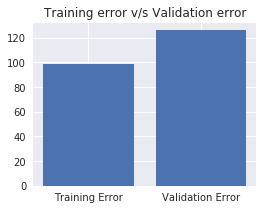

In [31]:
x_axis = ["Training Error", "Validation Error"]
error_values = [training_error, val_error]
plt.figure(figsize=(4,3))
plt.bar(x_axis, error_values)
plt.title("Training error v/s Validation error")
plt.show()

### 3. h. (Bonus) Use relief feature selection to improve your model.(10 marks)
<b>Answer: </b>

In [32]:
# Install the ReliefF package in the current Jupyter kernel.
#Referenced from: 1) https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
#                 2) https://epistasislab.github.io/scikit-rebate/installing/  

import sys
!{sys.executable} -m pip install skrebate

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
from skrebate import ReliefF

# Using ReliefF to rank features by importance
relief = ReliefF(n_jobs=-1)

# Since a majority of the columns are one-hot-encoded, we will not be passing it 
# to relief as it is counter-intuitive to lose one-hot-encoded columns to feature selection
# Hence, the only columns we are passing to ReliefF are mean_cost_by_location, mean_cost_by_rest_type,
# order_online and table_booking
cols = ['mean_cost_by_location', 'mean_cost_by_rest_type', 'table_booking', 'order_online']
#X_train_remaining = X_train.drop(cols, axis=1)
#X_val_remaining = X_val.drop(cols, axis=1)

X_train_subset = X_train[cols][:2000]
y_train_subset = y_train[:2000]

X_train_subset = X_train_subset.as_matrix()
y_train_subset = y_train_subset.as_matrix().flatten()

relief.fit(X_train_subset, y_train_subset)
top_features = relief.top_features_
print(f"Features ranked by importance:{top_features}\n")

# Find the indices of the best 2 features
feature_count = 2
index_of_best_features = np.argsort(top_features)[:feature_count]
print(f"Indices of the 4 best features: {index_of_best_features}\n")

Features ranked by importance:[1 0 3 2]

Indices of the 4 best features: [1 0]



In [34]:
# Building the train and val datasets using the 2 best features
# and the remaining one-hot-encoded features
cols_to_drop = []
for i in range(2):
    cols_to_drop.append(cols[index_of_best_features[i]])
cols_to_drop

relief_X_train = X_train
relief_X_train = relief_X_train.drop(cols_to_drop, axis=1)

relief_X_val = X_val
relief_X_val = relief_X_val.drop(cols_to_drop, axis=1)

In [35]:
# Build the model with the subset of features
best_model.fit(relief_X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
# Evaluate the training and validation error after feature selection
relief_train_predictions = best_model.predict(relief_X_train)
relief_train_error = mean_absolute_error(y_train, relief_train_predictions)

relief_val_predictions = best_model.predict(relief_X_val)
relief_val_error = mean_absolute_error(y_val, relief_val_predictions)

In [38]:
print(f"Training Error after feature selection using relief is: {relief_train_error}")
print(f"Validation Error after feature selection using relief is: {relief_val_error}")

Training Error after feature selection using relief is: 137.00976339794755
Validation Error after feature selection using relief is: 159.93847688726305


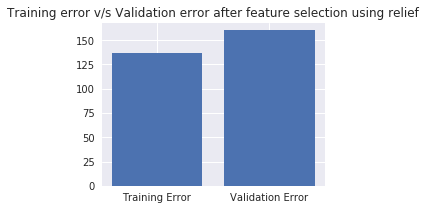

In [39]:
x_axis = ["Training Error", "Validation Error"]
error_values = [relief_train_error, relief_val_error]
plt.figure(figsize=(4,3))
plt.bar(x_axis, error_values)
plt.title("Training error v/s Validation error after feature selection using relief")
plt.show()

Hence, it is proved that feature selection has improved the model.